### Load packages

In [1]:
import pandas as pd
from pandas import json_normalize
import os
from datetime import datetime
import json
import glob
import re

# for figures
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from pandas.plotting import scatter_matrix

### Set project parameters for this run

In [5]:
# Project parameters

data_directory = "..\data"

algae_file = "env-epht-cyanobacteria-season-summary-2022"
algae_path = os.path.join(data_directory, algae_file + ".csv")
print(algae_path)

..\data\env-epht-cyanobacteria-season-summary-2022.csv


### Load algae bloom data

In [6]:
# Load algae bloom data file

algae_raw_df = pd.read_csv(algae_path)

In [7]:
algae_raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2535 entries, 0 to 2534
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Report Date                     2534 non-null   object 
 1   Report Time                     2530 non-null   object 
 2   Waterbody                       2534 non-null   object 
 3   Region                          2534 non-null   object 
 4   Municipality                    2533 non-null   object 
 5   Site                            2456 non-null   float64
 6   Station                         2534 non-null   object 
 7   Bloom Intensity                 2532 non-null   object 
 8   ApproximateShoreLengthOfBloom   517 non-null    object 
 9   ApproximateOffShoreLengthBloom  518 non-null    object 
 10  Report Frequency                2530 non-null   object 
 11  Affiliation                     2533 non-null   object 
 12  Web Status                      25

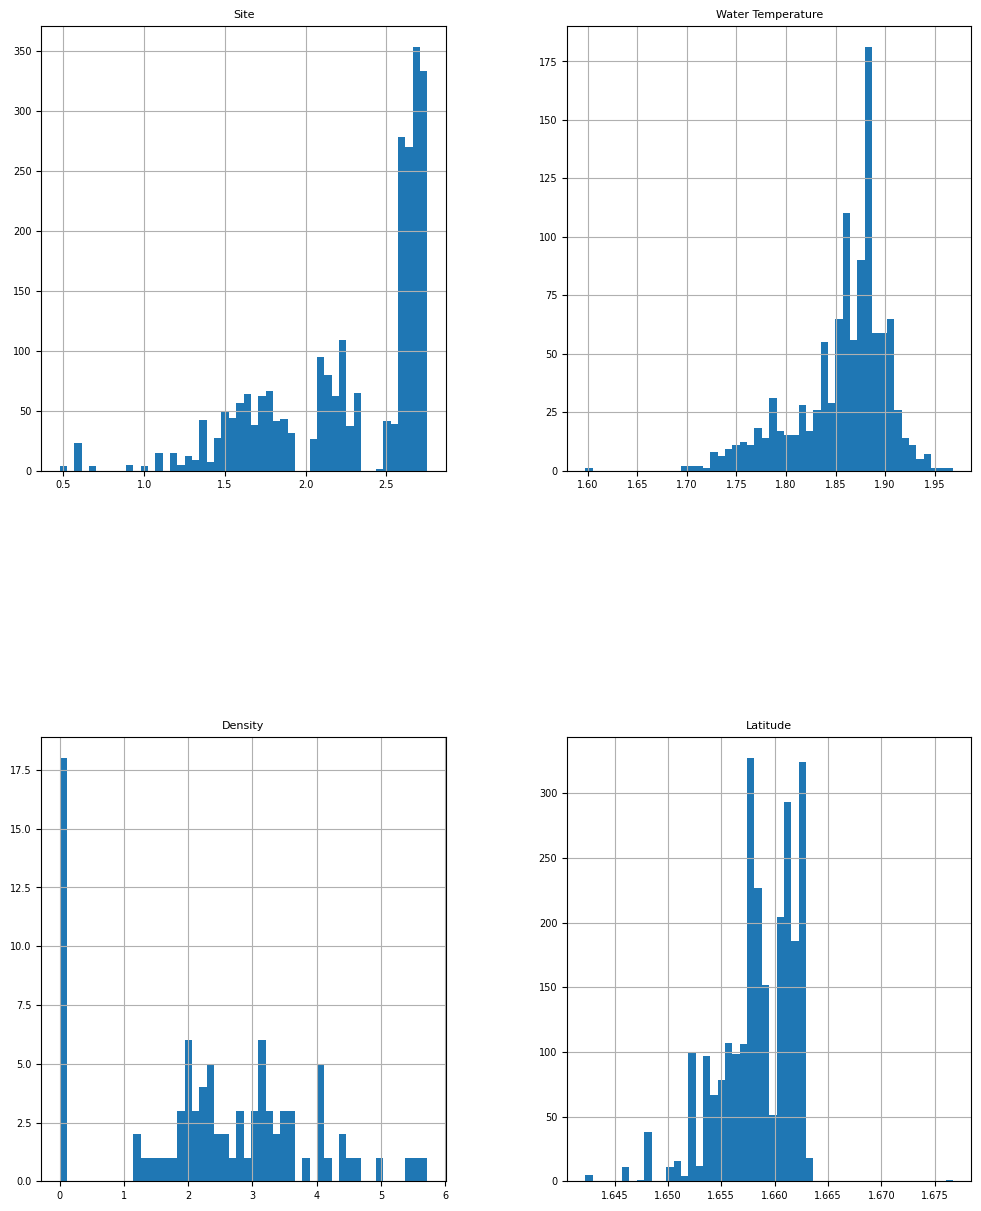

In [8]:
# Plot histograms of the numerical columns in the data

use_plots = True

if use_plots:
    
    # cols_to_ignore = ["Water Temperature", "Density", "Other Taxa"]
    cols_to_ignore = []

    plot_df = algae_raw_df.drop(
        columns=[c for c in cols_to_ignore if c in algae_raw_df.columns]
    )

    # Compute logs of the numeric columns
    numeric_df = plot_df.select_dtypes(include="number")

    # Make a new dataframe usig the logs instead of the raw values
    # log10(x + 1) avoids -inf for zeros
    # Keep only values where x + 1 > 0
    safe_numeric_df = numeric_df.where(numeric_df > -1)
    log_df = np.log10(safe_numeric_df + 1)
    # and then drop columns that are all nulls or NaN values
    log_df = log_df.dropna(axis=1, how="all")

    axes = log_df.hist(bins=50, figsize=(12, 15))

    for ax in axes.flatten():
        title = ax.get_title()
        wrapped_title = "\n".join(textwrap.wrap(title, width=20))
        ax.set_title(wrapped_title, fontsize=8)
        ax.tick_params(axis="y", labelsize=7)
        ax.tick_params(axis="x", labelsize=7)

    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    plt.show()


In [356]:
# Compute correlation coefficients for every numerical variable

if use_plots:

    corr_matrix = log_df.corr()
    print(corr_matrix["Total assets EOY"].sort_values(ascending=False))


In [357]:
# Calculate scatterplots for every numerical variable pair

if use_plots:

    # columns = ["Total assets EOY", "Total revenue (Rev Exp)", "Contributions gifts grants received (Rev Exp)",
    #            "Total expenses and disbursements (Rev Exp)", "Qualifying Distributions (Part XI)"]
    # pick just first four columns to look at by default
    columns = log_df.select_dtypes(include="number").columns[:4]

    axes = scatter_matrix(log_df[columns], figsize=(12,8), alpha=0.1)

    for ax in axes.flatten():
        
        ax.tick_params(axis="x", labelsize=7)
        ax.tick_params(axis="y", labelsize=7)
        xlabel = ax.get_xlabel()
        wrapped_xlabel = "\n".join(textwrap.wrap(xlabel, width=20))
        ax.set_xlabel(wrapped_xlabel, fontsize=8)
        ylabel = ax.get_ylabel()
        wrapped_ylabel = "\n".join(textwrap.wrap(ylabel, width=20))
        ax.set_ylabel(wrapped_ylabel, fontsize=8)
        
        # ax.set_xlabel(ax.get_xlabel(), fontsize=8)
        # ax.set_ylabel(ax.get_ylabel(), fontsize=8)

    plt.subplots_adjust(hspace=0.6, wspace=0.3)

    plt.show()

In [358]:
# Separate output files by year, if needed,
# and create output

# Force Object ID to string before output
if "Object ID" in output_df.columns:
    output_df["Object ID"] = (
        output_df["Object ID"]
        .astype(str)
        .str.strip()
        .str.replace(r"\.0$", "", regex=True)  # Remove any float artifacts
    )

if custom_output_file_term == None:
    custom_term = ""
else:
    custom_term = custom_output_file_term + "_"

if separate_output_by_year:
    for year in years:
        print(year)
        df_year = output_df[output_df["Year of Tax Period End Date"] == int(year)]
        if df_year.empty:
            continue
        output_filename = f"output_{custom_term}{year}_{timestamp}.csv"
        output_path = os.path.join(output_directory, output_filename)
        print(output_path)
        df_year.to_csv(output_path, index=False)
elif len(year_range) == 1:
    output_filename = f"output_{custom_term}{year_range[0]}_{timestamp}.csv"
    output_path = os.path.join(output_directory, output_filename)
    print(output_path)
    output_df.to_csv(output_path, index=False)
else:
    output_filename = f"output_{custom_term}{year_range}_{timestamp}.csv"
    output_path = os.path.join(output_directory, output_filename)
    print(output_path)
    output_df.to_csv(output_path, index=False)


2023
..\..\classes\CS5540_2026S\output\output_c4s_skedr_partv_2023_20260116_143105.csv
